### Импорт библиотек

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2
import albumentations as albu

from tqdm import tqdm
from sklearn.model_selection import train_test_split

from preprocessing.DateCategories import balance_day_data
from datasets import DaylightDataset
from tools import train_model, IoU, pixel_accuracy
from R2AttUnet_implementation import R2AttU_Net

# torch.cuda.empty_cache()
# torch.manual_seed(41)
# np.random.seed(41)
# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed(41)

### Пути 

In [2]:
IMAGE_PATH = 'C:/Users/tolik/information_technology/third_year/practice_project/CoreAnalysis-ML/data_for_study/photos/'
DAY_MASK_PATH = 'C:/Users/tolik/information_technology/third_year/practice_project/CoreAnalysis-ML/data_for_study/labels/daylight/label_'

### Подготовка данных

In [3]:
# разобьем все изображения на тренировочную, тестовую, валидационную части
X_train, X_test = train_test_split(balance_day_data, test_size = 0.065)
X_train, X_val = train_test_split(X_train, test_size = 0.118)

print('Размер X_train: {}\n'
      'Размер X_test: {}\n'
      'Размер X_val: {}'
      .format(len(X_train), len(X_test), len(X_val)))

Размер X_train: 371
Размер X_test: 30
Размер X_val: 50


### Аугментации

In [4]:
augment_1 = albu.Compose([
    albu.HorizontalFlip(),
    albu.VerticalFlip(),
    albu.RandomRotate90(),
    #albu.Transpose(),
    albu.OpticalDistortion(distort_limit=1, shift_limit=0.5),
    albu.GridDistortion()
])

### Датасеты (train, val, test)

In [5]:
train_set = DaylightDataset(img_path = IMAGE_PATH,
                               mask_path = DAY_MASK_PATH,
                               data = X_train[:371],
                               res = [768, 512],
                               augmentation=augment_1)
val_set = DaylightDataset(img_path = IMAGE_PATH,
                             mask_path = DAY_MASK_PATH,
                             res = [768, 512],
                             data = X_val)
test_set = DaylightDataset(img_path = IMAGE_PATH,
                              mask_path = DAY_MASK_PATH,
                              res = [768, 512],
                              data = X_test)

In [6]:
# Загрузчики данных
train_dataloader = DataLoader(dataset=train_set,
                              batch_size=5,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_set,
                              batch_size=5,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_set,
                            batch_size=1,
                            shuffle=False)

### Импорт модели, гиперпараметры

In [47]:
model = R2AttU_Net()
# import segmentation_models_pytorch as smp
# model = smp.Unet(encoder_name='resnet34', encoder_depth=5,
#                   encoder_weights='imagenet',
#                   decoder_use_batchnorm=True,
#                   decoder_channels=(128, 64, 32, 16, 8), 
#                   in_channels=3, classes=6,
#                   activation=None, aux_params=None)

In [48]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1.0e-3, weight_decay=1.0e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma = 0.01)
loss = torch.nn.CrossEntropyLoss()

### Обучение

In [50]:
history = train_model(model = model, N_classes = 6, model_name = 'R2AttUNet_daylight',
                optimizer = optimizer, scheduler = scheduler, loss = loss,
                train_dl = train_dataloader, val_dl = val_dataloader, num_epochs = 10, patch=True)

Epoch № 1


  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

train-loss: 1.7651207163527205
train-accuracy: 0.22085186898872725
train-iou: 0.07368468437781714


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:43<00:00,  4.13s/it]

validation-loss: 1.7318044567108155
validation-accuracy: 0.24061515465561226
validation-iou: 0.06926115790600197
saving model ...
Epoch № 2



  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

train-loss: 1.768915126774762
train-accuracy: 0.21942928459390512
train-iou: 0.07335230107452634


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:44<00:00,  4.18s/it]

validation-loss: 1.7283006286621094
validation-accuracy: 0.24851981026785716
validation-iou: 0.06923397369358762
Epoch № 3



  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

train-loss: 1.7734986975386335
train-accuracy: 0.21874898734831769
train-iou: 0.0736933039942516


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:42<00:00,  4.10s/it]

validation-loss: 1.729490270614624
validation-accuracy: 0.24168889508928568
validation-iou: 0.06764382073133603
Epoch № 4



  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

train-loss: 1.7623316809937761
train-accuracy: 0.22448349916402374
train-iou: 0.07414773193239808


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:42<00:00,  4.08s/it]

validation-loss: 1.7157178163528441
validation-accuracy: 0.25832290338010205
validation-iou: 0.07445823822101
saving model ...
Epoch № 5



  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

train-loss: 1.7702665103448403
train-accuracy: 0.21742228436982886
train-iou: 0.0752969458583857


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:42<00:00,  4.10s/it]

validation-loss: 1.7392762517929077
validation-accuracy: 0.22741284677933674
validation-iou: 0.06742027247530086


### Тестирование обученной модели

In [50]:
best_model_deeplab = torch.load('R2AttUnet_daylight.pth')

(0.0, 'Алевролит глинистый', 'Аргиллит')
(0.06, 'Алевролит глинистый')
(0.08, 'Песчаник')
(0.1, 'Алевролит глинистый')
(0.12, 'Песчаник')
(0.14, 'Алевролит глинистый')
(0.16, 'Песчаник')
(0.22, 'Аргиллит')
(0.24, 'Алевролит глинистый')
(0.26, 'Песчаник')
(0.28, 'Аргиллит', 'Алевролит глинистый')
(0.34, 'Алевролит глинистый')
(0.36, 'Песчаник')
(0.44, 'Алевролит глинистый')
(0.46, 'Аргиллит', 'Песчаник')
(0.5, 'Песчаник')
(0.66, 'Алевролит глинистый')
(0.68, 'Аргиллит')
(0.7, 'Алевролит глинистый')
(0.72, 'Аргиллит', 'Песчаник')
(0.88, 'Песчаник')
(0.9, 'Алевролит глинистый')
(0.92, 'Песчаник')
(0.94, 'Аргиллит')
(0.96, 'Алевролит глинистый')
(0.98, 'Алевролит глинистый')
На оригинальной маске присутствуют: 
Песчаник, Проба, Разлом, 

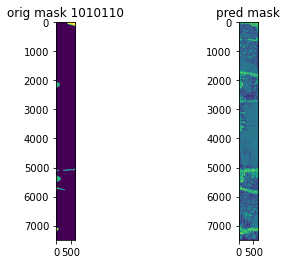

(0.0, 'Песчаник')
На оригинальной маске присутствуют: 
Переслаивание пород, Песчаник, 

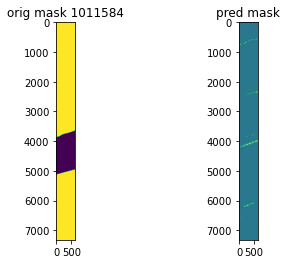

(0.0, 'Алевролит глинистый', 'Аргиллит')
(0.04, 'Песчаник')
(0.06, 'Алевролит глинистый')
(0.08, 'Песчаник')
(0.28, 'Алевролит глинистый')
(0.3, 'Аргиллит', 'Песчаник')
(0.32, 'Песчаник')
(0.36, 'Аргиллит')
(0.38, 'Песчаник')
(0.4, 'Песчаник')
(0.54, 'Аргиллит')
(0.56, 'Песчаник')
(0.6, 'Аргиллит')
(0.62, 'Песчаник')
(0.66, 'Аргиллит')
(0.68, 'Песчаник')
(0.7, 'Алевролит глинистый')
(0.72, 'Аргиллит')
(0.74, 'Песчаник', 'Алевролит глинистый')
(0.78, 'Аргиллит')
(0.8, 'Алевролит глинистый')
(0.82, 'Аргиллит')
(0.84, 'Алевролит глинистый')
(0.86, 'Аргиллит')
(0.88, 'Алевролит глинистый')
(0.9, 'Алевролит глинистый')
(0.98, 'Аргиллит')
На оригинальной маске присутствуют: 
Аргиллит, Разлом, 

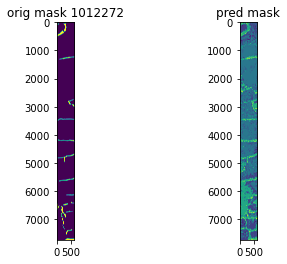

(0.0, 'Аргиллит', 'Алевролит глинистый')
(0.02, 'Песчаник')
(0.04, 'Алевролит глинистый')
(0.06, 'Песчаник')
(0.08, 'Алевролит глинистый')
(0.1, 'Песчаник')
(0.12, 'Алевролит глинистый')
(0.14, 'Алевролит глинистый')
(0.2, 'Песчаник')
(0.22, 'Алевролит глинистый')
(0.24, 'Песчаник')
(0.26, 'Песчаник')
(0.42, 'Алевролит глинистый')
(0.44, 'Песчаник')
(0.46, 'Алевролит глинистый')
(0.48, 'Песчаник')
(0.54, 'Алевролит глинистый')
(0.56, 'Песчаник')
(0.62, 'Алевролит глинистый')
(0.64, 'Песчаник')
(0.66, 'Алевролит глинистый')
(0.68, 'Песчаник')
(0.7, 'Алевролит глинистый')
(0.72, 'Песчаник')
(0.74, 'Алевролит глинистый')
(0.76, 'Песчаник')
(0.78, 'Алевролит глинистый')
(0.8, 'Песчаник')
(0.82, 'Алевролит глинистый')
(0.84, 'Песчаник')
(0.86, 'Алевролит глинистый')
(0.88, 'Песчаник')
(0.9, 'Песчаник')
(0.92, 'Алевролит глинистый')
(0.94, 'Алевролит глинистый')
(0.96, 'Аргиллит')
(0.98, 'Алевролит глинистый')
На оригинальной маске присутствуют: 
Переслаивание пород, Алевролит глинистый, Раз

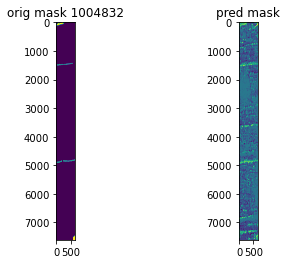

(0.0, 'Песчаник')
(0.36, 'Аргиллит')
(0.38, 'Песчаник')
На оригинальной маске присутствуют: 
Песчаник, Аргиллит, Разлом, 

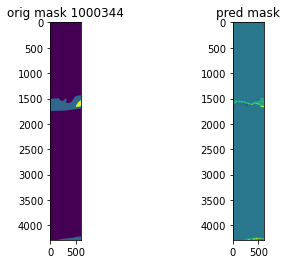

(0.0, 'Песчаник')
На оригинальной маске присутствуют: 
Переслаивание пород, Алевролит глинистый, Разлом, 

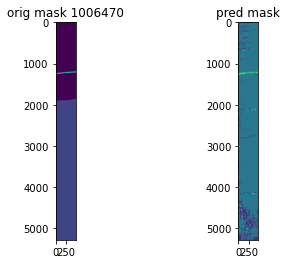

(0.0, 'Песчаник')
(0.02, 'Алевролит глинистый')
(0.04, 'Алевролит глинистый')
(0.06, 'Аргиллит', 'Песчаник')
(0.14, 'Песчаник')
(0.32, 'Алевролит глинистый')
(0.34, 'Песчаник')
(0.36, 'Песчаник')
(0.44, 'Алевролит глинистый')
(0.46, 'Песчаник')
(0.48, 'Алевролит глинистый')
(0.5, 'Алевролит глинистый')
(0.52, 'Аргиллит')
(0.54, 'Разлом', 'Алевролит глинистый')
(0.56, 'Песчаник')
(0.68, 'Алевролит глинистый')
(0.7, 'Песчаник')
(0.72, 'Алевролит глинистый')
(0.74, 'Песчаник')
(0.76, 'Алевролит глинистый')
(0.8, 'Песчаник')
(0.84, 'Алевролит глинистый')
(0.88, 'Песчаник')
(0.92, 'Алевролит глинистый')
(0.94, 'Алевролит глинистый')
(0.96, 'Переслаивание пород', 'Песчаник')
(0.98, 'Песчаник')
На оригинальной маске присутствуют: 
Переслаивание пород, Песчаник, Разлом, 

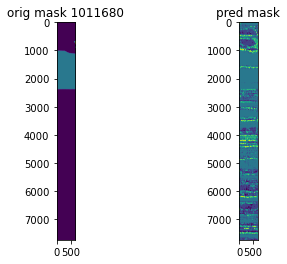

(0.0, 'Аргиллит')
(0.16, 'Алевролит глинистый')
(0.34, 'Песчаник')
(0.36, 'Алевролит глинистый')
(0.66, 'Песчаник')
(0.68, 'Алевролит глинистый')
(0.86, 'Аргиллит')
(0.88, 'Алевролит глинистый')
(0.9, 'Аргиллит')
(0.92, 'Аргиллит')
(0.94, 'Алевролит глинистый')
(0.96, 'Аргиллит')
На оригинальной маске присутствуют: 
Переслаивание пород, Алевролит глинистый, Разлом, 

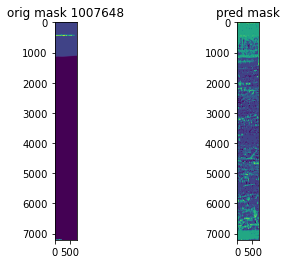

(0.0, 'Алевролит глинистый')
(0.02, 'Песчаник')
(0.46, 'Аргиллит')
(0.48, 'Песчаник')
(0.5, 'Аргиллит')
(0.52, 'Песчаник')
(0.54, 'Песчаник')
На оригинальной маске присутствуют: 
Песчаник, Проба, Разлом, 

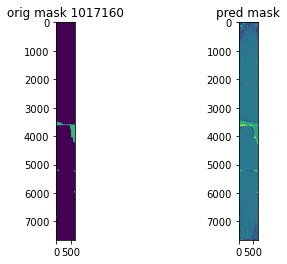

(0.0, 'Аргиллит')
На оригинальной маске присутствуют: 
Аргиллит, Разлом, 

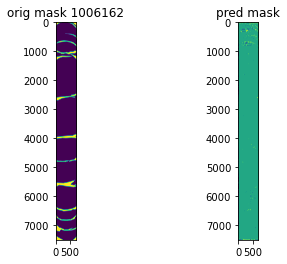

(0.0, 'Аргиллит', 'Алевролит глинистый')
(0.04, 'Песчаник')
(0.38, 'Аргиллит')
(0.4, 'Песчаник')
На оригинальной маске присутствуют: 
Переслаивание пород, Песчаник, Разлом, 

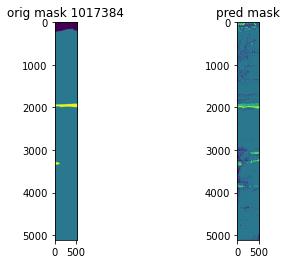

(0.0, 'Аргиллит', 'Алевролит глинистый')
(0.04, 'Аргиллит')
(0.16, 'Алевролит глинистый')
(0.18, 'Аргиллит')
(0.2, 'Алевролит глинистый')
(0.22, 'Аргиллит')
(0.24, 'Алевролит глинистый')
(0.26, 'Алевролит глинистый')
(0.28, 'Аргиллит')
(0.3, 'Алевролит глинистый')
(0.32, 'Аргиллит')
(0.34, 'Алевролит глинистый')
(0.6, 'Песчаник')
(0.62, 'Алевролит глинистый')
(0.64, 'Песчаник')
(0.66, 'Алевролит глинистый')
(0.72, 'Аргиллит')
(0.74, 'Алевролит глинистый')
(0.76, 'Аргиллит')
(0.98, 'Алевролит глинистый')
На оригинальной маске присутствуют: 
Песчаник, Разлом, 

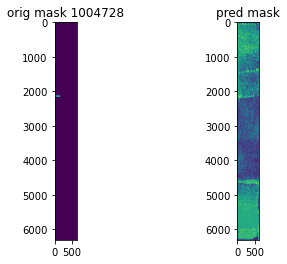

(0.0, 'Алевролит глинистый')
(0.26, 'Песчаник')
(0.28, 'Алевролит глинистый')
(0.3, 'Песчаник')
(0.32, 'Песчаник')
(0.34, 'Алевролит глинистый')
(0.36, 'Песчаник')
(0.38, 'Алевролит глинистый')
(0.4, 'Песчаник')
(0.42, 'Песчаник')
(0.44, 'Алевролит глинистый')
(0.46, 'Аргиллит', 'Песчаник')
(0.5, 'Песчаник')
(0.62, 'Аргиллит')
(0.64, 'Песчаник')
(0.72, 'Алевролит глинистый')
(0.74, 'Аргиллит')
(0.76, 'Песчаник', 'Алевролит глинистый')
(0.86, 'Песчаник')
(0.9, 'Аргиллит', 'Алевролит глинистый')
(0.98, 'Алевролит глинистый')
На оригинальной маске присутствуют: 
Алевролит глинистый, Разлом, 

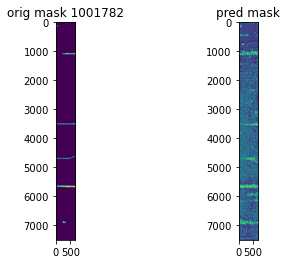

(0.0, 'Песчаник')
(0.38, 'Аргиллит')
(0.4, 'Песчаник')
(0.42, 'Песчаник')
(0.44, 'Аргиллит')
(0.46, 'Песчаник')
(0.48, 'Аргиллит')
(0.5, 'Песчаник')
(0.92, 'Переслаивание пород')
(0.94, 'Переслаивание пород')
(0.96, 'Песчаник')
(0.98, 'Песчаник')
На оригинальной маске присутствуют: 
Переслаивание пород, Песчаник, Проба, Разлом, 

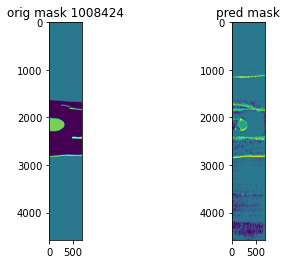

(0.0, 'Алевролит глинистый')
(0.06, 'Аргиллит')
(0.08, 'Алевролит глинистый')
(0.1, 'Аргиллит')
(0.12, 'Алевролит глинистый')
(0.16, 'Аргиллит')
(0.18, 'Аргиллит')
(0.22, 'Алевролит глинистый')
(0.4, 'Аргиллит')
(0.42, 'Алевролит глинистый')
(0.44, 'Аргиллит')
(0.46, 'Песчаник', 'Алевролит глинистый')
(0.52, 'Песчаник')
(0.78, 'Алевролит глинистый')
(0.8, 'Песчаник')
(0.82, 'Алевролит глинистый')
(0.84, 'Переслаивание пород', 'Песчаник')
(0.88, 'Переслаивание пород')
(0.9, 'Песчаник', 'Алевролит глинистый')
(0.96, 'Алевролит глинистый')
На оригинальной маске присутствуют: 
Переслаивание пород, Алевролит глинистый, Разлом, 

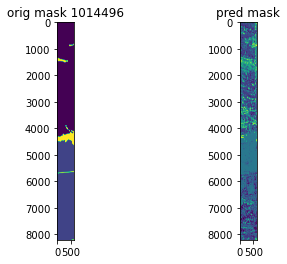

(0.0, 'Аргиллит')
(0.04, 'Песчаник', 'Алевролит глинистый')
(0.08, 'Алевролит глинистый')
(0.12, 'Песчаник')
(0.14, 'Песчаник')
(0.16, 'Алевролит глинистый')
(0.18, 'Песчаник')
(0.2, 'Алевролит глинистый')
(0.22, 'Переслаивание пород', 'Песчаник')
(0.24, 'Алевролит глинистый')
(0.26, 'Переслаивание пород', 'Песчаник')
(0.3, 'Алевролит глинистый')
(0.34, 'Аргиллит')
(0.36, 'Песчаник', 'Алевролит глинистый')
(0.44, 'Песчаник')
(0.64, 'Алевролит глинистый')
(0.68, 'Песчаник')
(0.7, 'Алевролит глинистый')
(0.72, 'Песчаник')
(0.74, 'Алевролит глинистый')
(0.84, 'Песчаник')
(0.86, 'Алевролит глинистый')
На оригинальной маске присутствуют: 
Алевролит глинистый, Песчаник, Разлом, 

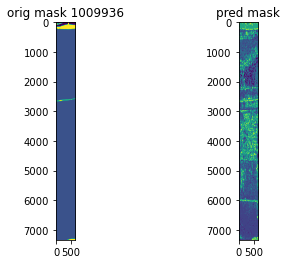

(0.0, 'Аргиллит')
(0.32, 'Алевролит глинистый')
(0.34, 'Аргиллит')
(0.36, 'Аргиллит')
На оригинальной маске присутствуют: 
Алевролит глинистый, Аргиллит, Разлом, 

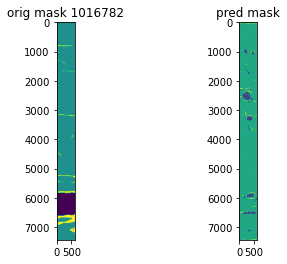

(0.0, 'Алевролит глинистый')
(0.04, 'Песчаник')
(0.06, 'Песчаник')
(0.08, 'Алевролит глинистый')
(0.1, 'Аргиллит', 'Песчаник')
(0.16, 'Алевролит глинистый')
(0.18, 'Аргиллит')
(0.2, 'Песчаник', 'Алевролит глинистый')
(0.22, 'Песчаник')
(0.68, 'Аргиллит')
(0.7, 'Алевролит глинистый')
(0.72, 'Аргиллит')
(0.8, 'Песчаник', 'Алевролит глинистый')
(0.9, 'Алевролит глинистый')
На оригинальной маске присутствуют: 
Песчаник, Проба, Разлом, 

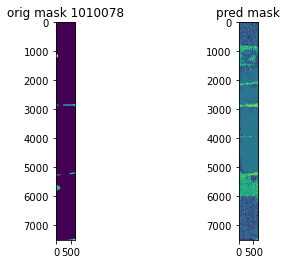

(0.0, 'Аргиллит', 'Переслаивание пород')
(0.04, 'Аргиллит')
(0.12, 'Алевролит глинистый')
(0.14, 'Алевролит глинистый')
(0.18, 'Аргиллит')
(0.2, 'Аргиллит')
На оригинальной маске присутствуют: 
Песчаник, Разлом, 

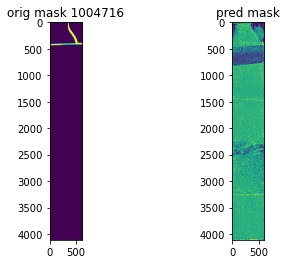

(0.0, 'Аргиллит')
На оригинальной маске присутствуют: 
Аргиллит, Разлом, 

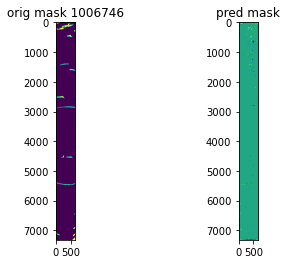

(0.0, 'Алевролит глинистый')
(0.04, 'Песчаник')
(0.14, 'Алевролит глинистый')
(0.16, 'Аргиллит')
(0.18, 'Аргиллит')
(0.2, 'Алевролит глинистый')
(0.22, 'Аргиллит')
(0.24, 'Песчаник', 'Алевролит глинистый')
(0.26, 'Песчаник')
(0.58, 'Алевролит глинистый')
(0.6, 'Аргиллит')
(0.62, 'Алевролит глинистый')
(0.64, 'Аргиллит')
(0.7, 'Алевролит глинистый')
(0.72, 'Алевролит глинистый')
(0.74, 'Песчаник')
(0.76, 'Алевролит глинистый')
(0.78, 'Песчаник')
(0.8, 'Алевролит глинистый')
(0.82, 'Аргиллит')
(0.84, 'Алевролит глинистый')
(0.92, 'Песчаник')
(0.94, 'Алевролит глинистый')
(0.96, 'Песчаник')
(0.98, 'Алевролит глинистый')
На оригинальной маске присутствуют: 
Переслаивание пород, Алевролит глинистый, Разлом, 

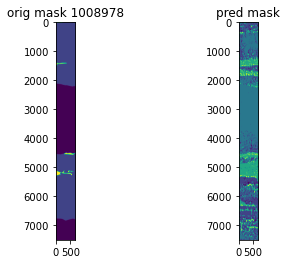

(0.0, 'Песчаник')
На оригинальной маске присутствуют: 
Песчаник, 

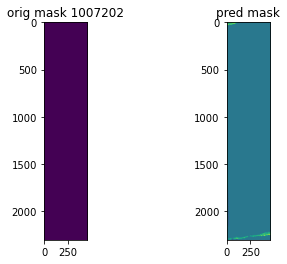

(0.0, 'Песчаник', 'Алевролит глинистый', 'Аргиллит')
(0.02, 'Аргиллит', 'Песчаник')
(0.1, 'Переслаивание пород')
(0.12, 'Песчаник')
(0.14, 'Аргиллит')
(0.16, 'Песчаник')
На оригинальной маске присутствуют: 
Переслаивание пород, Песчаник, Разлом, 

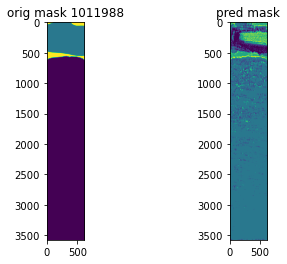

(0.0, 'Аргиллит')
(0.22, 'Алевролит глинистый')
(0.24, 'Алевролит глинистый')
(0.76, 'Песчаник')
(0.78, 'Алевролит глинистый')
(0.8, 'Алевролит глинистый')
(0.88, 'Аргиллит')
(0.9, 'Алевролит глинистый')
(0.92, 'Алевролит глинистый')
(0.96, 'Аргиллит')
(0.98, 'Алевролит глинистый')
На оригинальной маске присутствуют: 
Песчаник, 

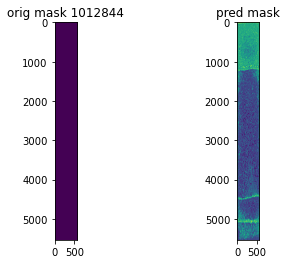

(0.0, 'Аргиллит', 'Алевролит глинистый', 'Песчаник')
(0.02, 'Аргиллит')
(0.04, 'Песчаник')
(0.06, 'Аргиллит')
(0.08, 'Песчаник')
(0.12, 'Алевролит глинистый')
(0.14, 'Аргиллит')
(0.16, 'Песчаник', 'Алевролит глинистый')
(0.18, 'Аргиллит')
(0.26, 'Песчаник', 'Алевролит глинистый')
(0.3, 'Аргиллит')
(0.36, 'Песчаник', 'Алевролит глинистый')
(0.44, 'Аргиллит')
(0.5, 'Алевролит глинистый')
(0.52, 'Аргиллит')
(0.56, 'Алевролит глинистый')
(0.58, 'Аргиллит')
(0.6, 'Песчаник')
(0.62, 'Песчаник')
(0.64, 'Аргиллит')
(0.66, 'Аргиллит')
(0.68, 'Алевролит глинистый')
(0.7, 'Аргиллит')
(0.72, 'Алевролит глинистый')
(0.74, 'Аргиллит')
(0.82, 'Песчаник', 'Алевролит глинистый')
(0.84, 'Аргиллит')
(0.92, 'Алевролит глинистый')
(0.96, 'Аргиллит')
(0.98, 'Алевролит глинистый')
На оригинальной маске присутствуют: 
Переслаивание пород, Алевролит глинистый, Разлом, 

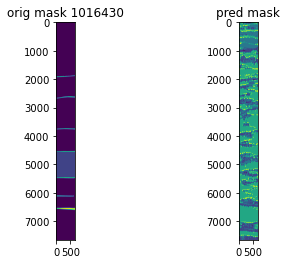

(0.0, 'Алевролит глинистый')
(0.12, 'Песчаник')
(0.14, 'Алевролит глинистый')
(0.16, 'Песчаник')
(0.82, 'Алевролит глинистый')
(0.84, 'Песчаник')
(0.9, 'Алевролит глинистый')
(0.92, 'Алевролит глинистый')
На оригинальной маске присутствуют: 
Песчаник, Разлом, 

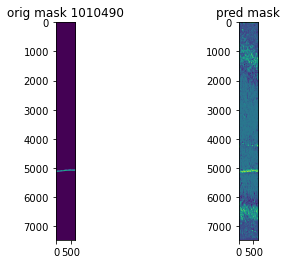

(0.0, 'Песчаник')
(0.06, 'Алевролит глинистый')
(0.08, 'Песчаник')
(0.1, 'Песчаник')
(0.56, 'Алевролит глинистый')
(0.58, 'Песчаник')
(0.68, 'Алевролит глинистый')
(0.7, 'Песчаник')
(0.72, 'Алевролит глинистый')
(0.74, 'Алевролит глинистый')
На оригинальной маске присутствуют: 
Переслаивание пород, Алевролит глинистый, Песчаник, Разлом, 

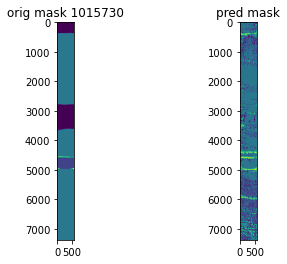

(0.0, 'Алевролит глинистый')
(0.02, 'Песчаник')
На оригинальной маске присутствуют: 
Песчаник, Разлом, 

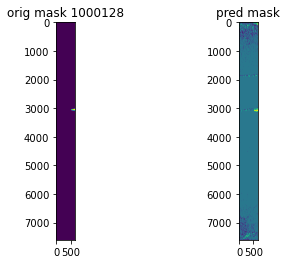

(0.0, 'Песчаник')
На оригинальной маске присутствуют: 
Алевролит глинистый, 

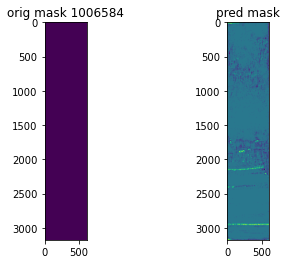

(0.0, 'Алевролит глинистый')
(0.02, 'Аргиллит')
(0.04, 'Алевролит глинистый')
(0.16, 'Песчаник')
(0.18, 'Алевролит глинистый')
(0.2, 'Песчаник')
(0.22, 'Аргиллит')
(0.24, 'Песчаник', 'Алевролит глинистый')
(0.28, 'Алевролит глинистый')
(0.34, 'Песчаник')
(0.36, 'Песчаник')
(0.5, 'Аргиллит')
(0.52, 'Песчаник')
(0.6, 'Алевролит глинистый')
(0.62, 'Песчаник')
(0.64, 'Алевролит глинистый')
(0.66, 'Песчаник')
(0.68, 'Алевролит глинистый')
(0.7, 'Песчаник')
(0.72, 'Алевролит глинистый')
(0.74, 'Песчаник')
(0.76, 'Песчаник')
(0.84, 'Алевролит глинистый')
(0.86, 'Песчаник')
(0.88, 'Алевролит глинистый')
(0.98, 'Аргиллит')
На оригинальной маске присутствуют: 
Переслаивание пород, Алевролит глинистый, Песчаник, Разлом, 

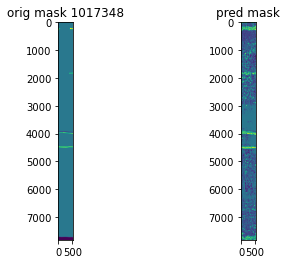

In [58]:
from PIL import Image
PATH = 'C:/Users/tolik/information_technology/third_year/practice_project/CoreAnalysis-ML/data_for_study/predict'
from tools import text_generation

classes = ['Переслаивание пород', 'Алевролит глинистый',
                   'Песчаник', 'Аргиллит', 'Проба', 'Разлом']

for id in X_test:
    img = Image.open(f'C:/Users/tolik/information_technology/third_year/practice_project/CoreAnalysis-ML/data_for_study/photos/{id}.jpeg')
    pred = model_predict_try(best_model_deeplab, img, 768, 512)
    text = text_generation_local(pred, 'daylight', step_h=50, step_w=3)
    for tup in text:
        print(tup)
    
    orig_mask = np.load(f'C:/Users/tolik/information_technology/third_year/practice_project/CoreAnalysis-ML/data_for_study/labels/daylight/label_{id}.npz')['x']
    print('На оригинальной маске присутствуют: ')
    for i in np.unique(orig_mask):
        print(classes[i], end=', ')
    ax1 = plt.subplot(121)
    plt.imshow(orig_mask)
    ax1.set_title(f'orig mask {id}')
    
    
    ax2 = plt.subplot(122)
    plt.imshow(pred)
    ax2.set_title('pred mask')
    
    plt.pause(0.001)

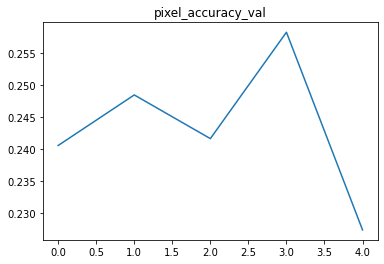

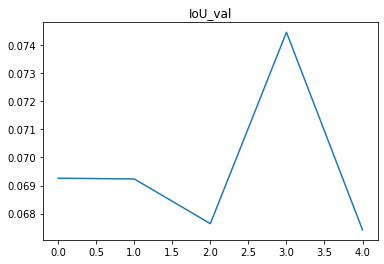

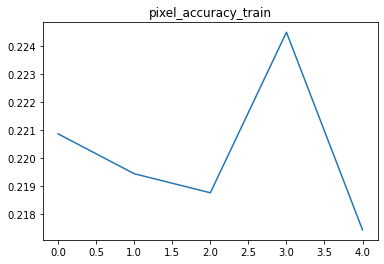

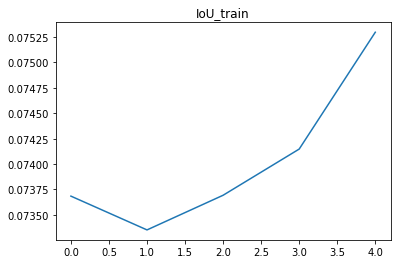

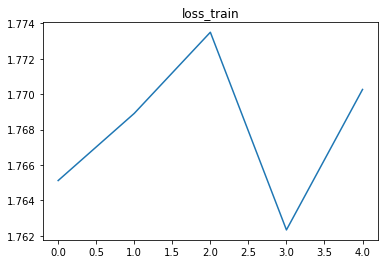

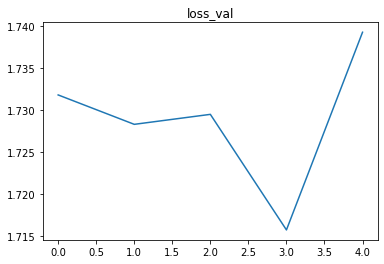

In [52]:
for key in history.keys():
    plt.plot(np.arange(5), history[key])
    plt.title(key)
    plt.pause(0.001)